In [1]:
import numpy as np
import seaborn as sns
from scipy.stats import beta, uniform, poisson, bernoulli
import scipy.integrate as integrate
import matplotlib.pyplot as plt

In [5]:
y = np.array([20, 2])
n = np.array([50, 3])

In [3]:
y = np.array([20, 20])
n = np.array([50, 30])

In [8]:
y = np.array([1, 1])
n = np.array([1, 1])

In [6]:
def probOpt(y, n):
    k = y.size
    ans = np.zeros(k)
    for i in range(0, k):
        indx = np.delete(np.arange(0,k), i, 0)
        def f(x):
            r = beta.pdf(x, y[i]+1, n[i]-y[i]+1)
            for j in indx:
                r = r * beta.cdf(x, y[j]+1, n[j]-y[j]+1)
            return r
        ans[i] = integrate.quad(f, 0, 1)[0]
    return ans


In [7]:
probOpt(y, n)

array([0.1921303, 0.8078697])

In [ ]:
def simPost(y, n, ndraws):
    k = y.size
    ans = np.zeros([ndraws, k])
    no = n-y
    for i in range(0, k):
        ans[:, i] = beta.rvs(y[i]+1, no[i]+1, size=ndraws)
    return ans

def probWinner(post):
    k = y.size
    w = np.zeros(k)
    n = np.argmax(post, 1) #np.sort(np.max(post, 0))
    for i in range(0, k):
        w[i] = np.sum(n==i)
    return w/sum(w)

def computeWinProb(y, n, ndraws):
    return probWinner(simPost(y, n, ndraws))

In [ ]:
computeWinProb(y, n , 1000)

array([0.008, 0.992])

In [85]:
class BMAP:
    def __init__(self, narms, sim=True):
        self.narms = narms
        self.theta = self.genParameters(self.narms, True)
        self.muopt = self.theta.max()
        self.mupred = np.zeros(narms)
        self.loss = []

    def genParameters(self, narms, verbose=False):
        theta = uniform.rvs(size=narms)
        if verbose: print('Parameters of the arms: {}'.format(theta))
        return theta
    
    def regret(self, muopt, mupred, n):
        result = 0
        for a in range(len(n)):
            result += n[a]*(muopt - mupred[a])
        return result

    def getpriors(self):
        y = np.ones(self.narms)
        n = np.ones(self.narms)
        return y, n

    def run(self, nexp):
        self.y, self.n = self.getpriors()
        self.w = probOpt(self.y, self.n)
        for i in range(nexp):
            numobs = 100 #1000
            l = 0
            ntemp = np.zeros_like(self.n)
            for j in range(numobs):
                arm = np.random.choice(self.narms, 1, p=self.w)[0]
                succes = bernoulli.rvs(self.theta[arm], size=1)[0]
                self.n[arm] += 1
                self.y[arm] += succes
                ntemp[arm] += 1
            self.w = probOpt(self.y, self.n)
            l = self.regret(self.muopt, self.theta, ntemp)
            self.loss.append(l)

    

In [86]:
bandit = BMAP(5)

Parameters of the arms: [0.79303318 0.8320197  0.26840587 0.93906207 0.78343392]


In [87]:
bandit.run(100)

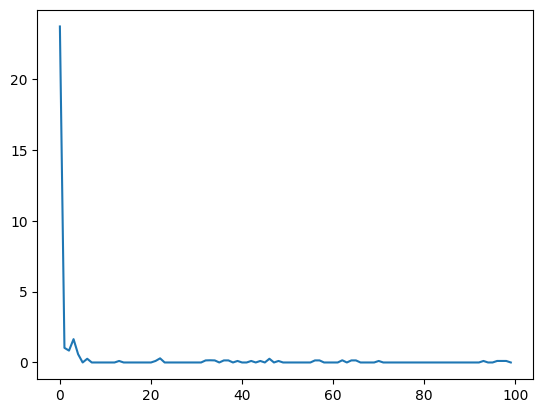

In [88]:
plt.plot(bandit.loss)

In [83]:
bandit.theta

array([0.51778816, 0.11737446, 0.4402499 , 0.61311282, 0.89815347])

In [84]:
bandit.w

array([2.83455508e-03, 1.33095065e-04, 6.91309777e-04, 2.84717629e-03,
       9.93493864e-01])

In [63]:
bandit.y/bandit.n

array([0.0766129 , 0.06388206, 0.01369863, 0.01449275, 0.05288462])